In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics.pairwise import cosine_similarity

Load + View data

In [3]:
data_preprocess_eda_dir = os.getcwd()
data_dir = os.path.abspath(os.path.join(data_preprocess_eda_dir, "..", "data"))

output_csv = os.path.join(data_dir, "antique_train_with_embeddings.csv")

def parse_embedding(text):
    return np.array(literal_eval(text), dtype=np.float64)

train_df = pd.read_csv(output_csv, converters={
    "query_embedding": parse_embedding,
    "doc_embedding": parse_embedding
})

print("Train Combined DataFrame after reloading:")
display(train_df.head())

print(f"Query Embedding Type: {type(train_df['query_embedding'].iloc[0])}")
print(f"Document Embedding Type: {type(train_df['doc_embedding'].iloc[0])}")

Train Combined DataFrame after reloading:


,query_id,doc_id,relevance,iteration,query_text,doc_text,query_embedding,doc_embedding
0,2531329,2531329_0,4,U0,Why do some men spit into the urinal before ur...,I do it all the time. It is kind of a ritual ...,"[0.06218868866562843, -0.015421810559928417, 0...","[0.0625365749001503, 0.04067419469356537, -0.0..."
1,2531329,2531329_5,4,Q0,Why do some men spit into the urinal before ur...,To clear out the mucus deep down in the throat...,"[0.06218868866562843, -0.015421810559928417, 0...","[0.08527150005102158, -0.03753829002380371, 0...."
2,2531329,2531329_4,3,Q0,Why do some men spit into the urinal before ur...,"maybe they want a target to hit. Well, I gues...","[0.06218868866562843, -0.015421810559928417, 0...","[0.13832318782806396, -0.0030896335374563932, ..."
3,2531329,2531329_7,3,Q0,Why do some men spit into the urinal before ur...,Where else would we spit?... Apart from sports...,"[0.06218868866562843, -0.015421810559928417, 0...","[0.0586501806974411, 0.019921783357858658, 0.0..."
4,2531329,2531329_6,3,Q0,Why do some men spit into the urinal before ur...,Because they have a cough or phlegm and hacked...,"[0.06218866631388664, -0.015421760268509388, 0...","[0.08216521143913269, 0.040984902530908585, 0...."


Query Embedding Type: <class 'numpy.ndarray'>
Document Embedding Type: <class 'numpy.ndarray'>


EDA

In [4]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

query_emb_2d = tsne.fit_transform(pca.fit_transform(np.vstack(train_df["query_embedding"])))
doc_emb_2d = tsne.fit_transform(pca.fit_transform(np.vstack(train_df["doc_embedding"])))

In [5]:
train_df["query_emb_x"], train_df["query_emb_y"] = query_emb_2d[:, 0], query_emb_2d[:, 1]
train_df["doc_emb_x"], train_df["doc_emb_y"] = doc_emb_2d[:, 0], doc_emb_2d[:, 1]

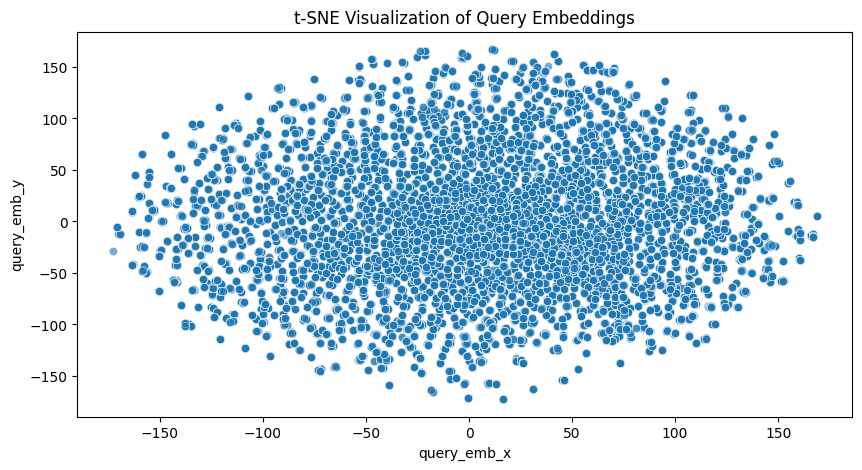

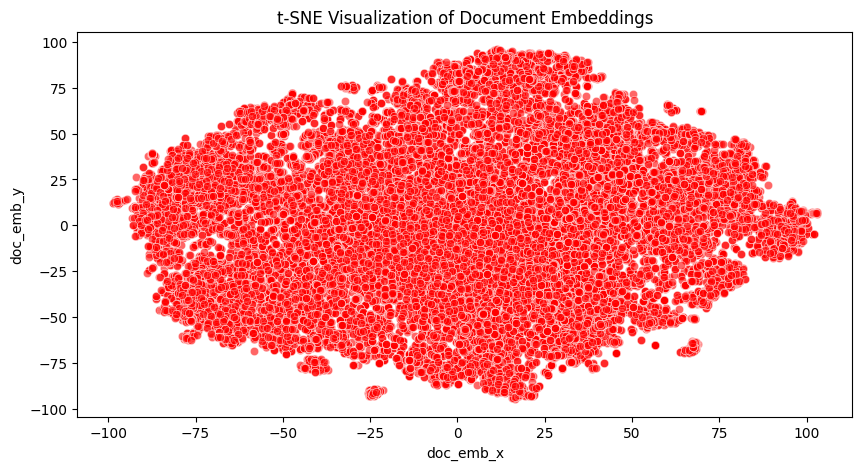

In [6]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x="query_emb_x", y="query_emb_y", data=train_df, alpha=0.6)
plt.title("t-SNE Visualization of Query Embeddings")
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="doc_emb_x", y="doc_emb_y", data=train_df, alpha=0.6, color="red")
plt.title("t-SNE Visualization of Document Embeddings")
plt.show()

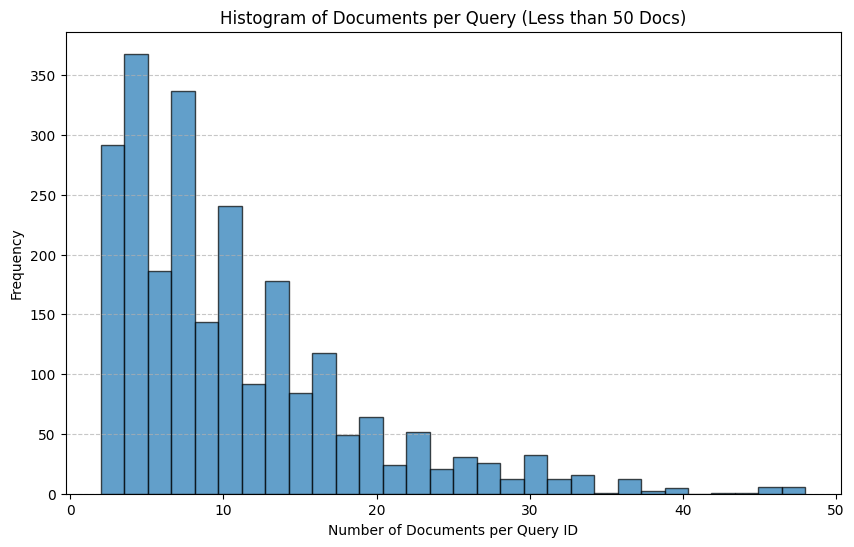

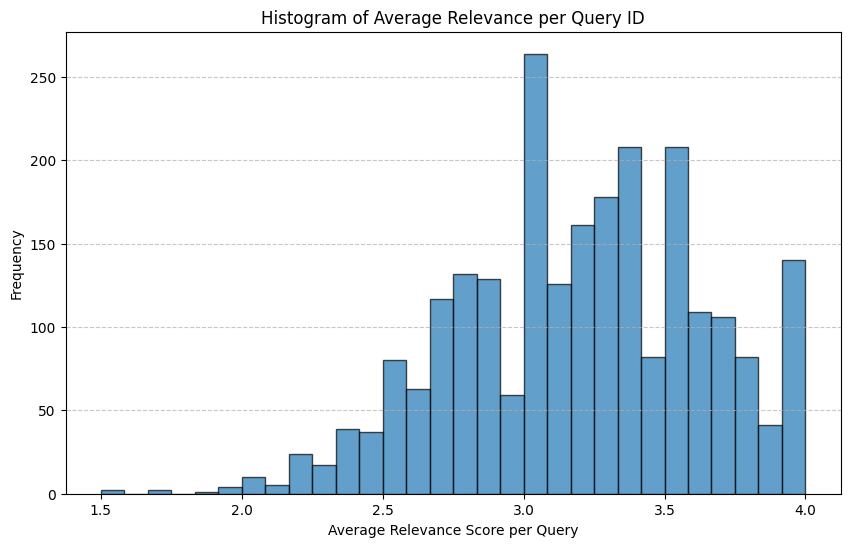

In [7]:
doc_counts = train_df["query_id"].value_counts()

filtered_doc_counts = doc_counts[doc_counts < 50]

plt.figure(figsize=(10, 6))
plt.hist(filtered_doc_counts, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Number of Documents per Query ID")
plt.ylabel("Frequency")
plt.title("Histogram of Documents per Query (Less than 50 Docs)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

avg_relevance_per_query = train_df.groupby("query_id")["relevance"].mean()

plt.figure(figsize=(10, 6))
plt.hist(avg_relevance_per_query, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Average Relevance Score per Query")
plt.ylabel("Frequency")
plt.title("Histogram of Average Relevance per Query ID")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

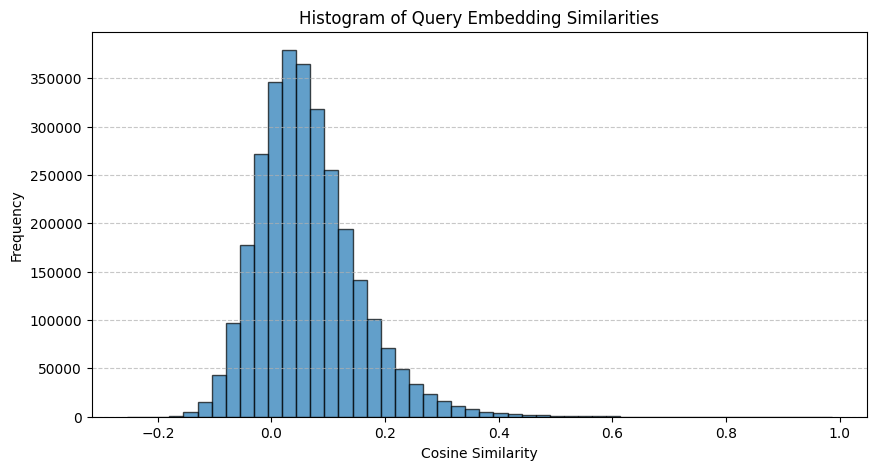

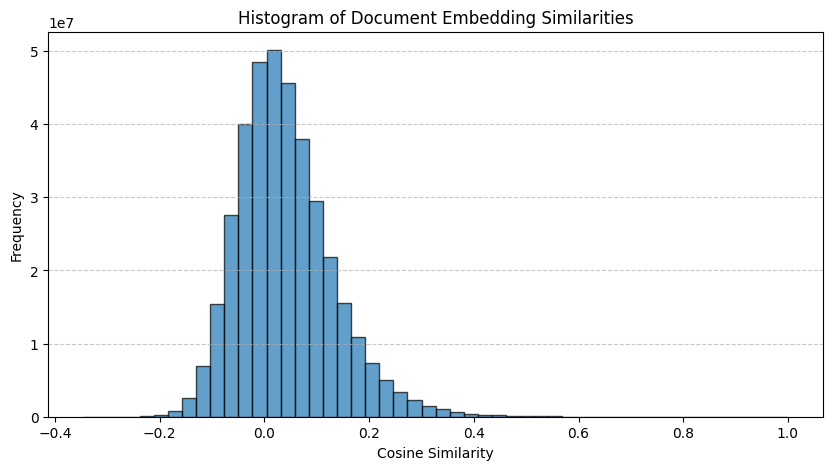

In [8]:
query_embeddings = np.stack(train_df.groupby("query_id")["query_embedding"].first().values)
doc_embeddings = np.stack(train_df["doc_embedding"].values)

query_cosine_sim = cosine_similarity(query_embeddings)

doc_cosine_sim = cosine_similarity(doc_embeddings)

query_sim_values = query_cosine_sim[np.triu_indices(len(query_embeddings), k=1)]
doc_sim_values = doc_cosine_sim[np.triu_indices(len(doc_embeddings), k=1)]

plt.figure(figsize=(10, 5))
plt.hist(query_sim_values, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Query Embedding Similarities")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(doc_sim_values, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Histogram of Document Embedding Similarities")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()